<h1>DSCI-552 Final Project</h1>
<br>
<font size="4">Morgan Gautho | GitHub: morgangauth | 3944-8632-72</font>
    

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from google.colab import drive 
import shutil
import cv2

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers



import warnings
warnings.filterwarnings('ignore')

In [3]:
drive.mount("/content/drive")



Mounted at /content/drive


# 1. Transfer Learning for Image Classification

## (b) Data Exploration and Pre-processing

i. Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore,
you encode your classes using one-hot encoding and Classes.xlsx.

ii. Randomly select d0.7nie images from each folder as your training set, d0.15nie
as validation set, and the rest as your test set, where ni
is the number of
images in folder i and dxe is the ceiling of x.

iii. In order for all the images to have the same size, zero-pad or resize the images
in your dataset. This can be done using various tools, including OpenCV.


In [4]:
# one time use to create folders
root_dir = '/content/drive/MyDrive/ColabNotebooks/Project/'
if not os.path.exists(root_dir + '/output'):
  os.makedirs(root_dir +'/output')
root_dir = '/content/drive/MyDrive/ColabNotebooks/Project/output/'
for i in ['train','test','val']:
  if not os.path.exists(root_dir + i):
    os.makedirs(root_dir + i)


In [5]:
def partition_pct(lst, point):
    idx =  math.ceil(len(lst) * point)
    return lst[:idx], lst[idx:]

directory = "/content/drive/MyDrive/ColabNotebooks/Project/Data/"
names = pd.read_excel(directory + "Classes.xlsx", names=["Folder","Class"])  
for i in names["Folder"]:
  if not os.path.exists(root_dir + '/train/'+i):
    os.makedirs(root_dir +'/train/'+i)
  if not os.path.exists(root_dir + '/test/'+i):
    os.makedirs(root_dir +'/test/'+i)
  if not os.path.exists(root_dir + '/val/'+i):
    os.makedirs(root_dir +'/val/'+i)
  lst = os.listdir(directory + '/images/' + i)
  cnv_list_70, cnv_list_30 = partition_pct(lst, .7)
  cnv_list_15_1, cnv_list_15_2 = partition_pct(cnv_list_30, .5)
  print("Starting directory split of " + i + "...")
  for (file_list, dirname) in ((cnv_list_70, root_dir +'/train/'+i),
                             (cnv_list_15_1, root_dir +'/test/'+i),
                             (cnv_list_15_2, root_dir +'/val/'+i)):
    for f in file_list:
      path = directory + '/images/' + i + '/' + f
      img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
      width = 224
      height = 224
      dim = (width, height)
      resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
      cv2.imwrite(dirname + '/' + f, resized)
      #shutil.copy(directory + '/images/' + i + '/' + f, dirname)
  
  

Starting directory split of 005.Crested_Auklet...
Starting directory split of 013.Bobolink...
Starting directory split of 015.Lazuli_Bunting...
Starting directory split of 023.Brandt_Cormorant...
Starting directory split of 040.Olive_sided_Flycatcher...
Starting directory split of 041.Scissor_tailed_Flycatcher...
Starting directory split of 067.Anna_Hummingbird...
Starting directory split of 072.Pomarine_Jaeger...
Starting directory split of 076.Dark_eyed_Junco...
Starting directory split of 081.Pied_Kingfisher...
Starting directory split of 082.Ringed_Kingfisher...
Starting directory split of 086.Pacific_Loon...
Starting directory split of 099.Ovenbird...
Starting directory split of 104.American_Pipit...
Starting directory split of 127.Savannah_Sparrow...
Starting directory split of 135.Bank_Swallow...
Starting directory split of 141.Artic_Tern...
Starting directory split of 149.Brown_Thrasher...
Starting directory split of 156.White_eyed_Vireo...
Starting directory split of 168.Kentu

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 5
#root_dir = '/content/drive/MyDrive/ColabNotebooks/Project/output/' defined above
train_dataset = image_dataset_from_directory(root_dir + 'train/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical',
                                             seed=42)
test_dataset = image_dataset_from_directory(root_dir + 'test/',
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical',
                                             seed=42)
validation_dataset = image_dataset_from_directory(root_dir + 'val/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical',
                                             seed=42)
num_classes = len(names)
#train_data = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
#val_data = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

Found 827 files belonging to 20 classes.
Found 185 files belonging to 20 classes.
Found 178 files belonging to 20 classes.


## (c) Transfer Learning

i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train
them. In such cases, one usually uses transfer learning, which uses deep
learning models that are trained on very large datasets such as ImageNet
as feature extractors. The idea is that such deep networks have learned to
extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the
last layer or the last few layers of the pre-trained network are removed, and
the response of the layer before the removed layers to the images in the new
dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only around 50-60 images per class. Given
that we have 20 classes, training a deep network with such a small dataset
may not yield desirable results. 

In this project, you will use pre-trained models EfficientNetB0 and VGG16. For both pre-trained networks, you will only
train the last fully connected layer, and will freeze all layers before them (i.e.
we do not change their parameters during training) and use the outputs of the
penultimate layer in the original pre-trained model as the features extracted
from each image.


In [7]:
from tensorflow.keras.applications import EfficientNetB0
base_model1 = EfficientNetB0(include_top=False, weights='imagenet')
base_model1.trainable = False ## Not trainable weights

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

base_model2 = VGG16(weights="imagenet", include_top=False)
base_model2.trainable = False ## Not trainable weights



58889256/58889256 [==============================] - 0s 0us/step



ii. To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast,
and translate images in your training set for image augmentation. You can
use various tools to do this, including OpenCV.

In [8]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(fill_mode= "nearest", height_factor = (-0.3, 0.3))
    ],
    name="img_augmentation",
)

iii. Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size,
but a batch size of 5 seems reasonable.

In [9]:
# Rebuild model

def build_model1():
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)

    base_model = EfficientNetB0(include_top=False, input_tensor = x, weights='imagenet')
    base_model.trainable = False ## Not trainable weights
    
    # Rebuild top
    # relu activation functions
    # softmax
    # batch normalization 
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.Dense(num_classes, activation="relu")(x) 
    x = layers.BatchNormalization()(x)
    
    
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    
    # Compile
    model = tf.keras.Model(inputs, outputs, name="efficient")
    print("test")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [10]:
model1 = build_model1()



test


In [11]:
# Rebuild model

def build_model2():
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)

    base_model = VGG16(include_top=False, input_tensor = x, weights='imagenet')
    base_model.trainable = False ## Not trainable weights
    
    # Rebuild top
    # relu activation functions
    # softmax
    # batch normalization 
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.Dense(num_classes, activation="relu")(x) 
    x = layers.BatchNormalization()(x)
    
    
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    
    # Compile
    model = tf.keras.Model(inputs, outputs, name="vgg")
    print("test")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [12]:
model2 = build_model2()

test



iv. Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs
(preferably 100 epochs) and perform early stopping using the validation set.
Keep the network parameters that have the lowest validation error. Plot the
training and validation errors vs. epochs.
 

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
epochs = 50
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


history1 = model1.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[es])

Epoch 1/50


166/166 [==============================] - 88s 452ms/step - loss: 2.4880 - accuracy: 0.2346 - val_loss: 1.5065 - val_accuracy: 0.4944
Epoch 2/50
166/166 [==============================] - 73s 440ms/step - loss: 1.8410 - accuracy: 0.4172 - val_loss: 1.0698 - val_accuracy: 0.7022
Epoch 3/50
166/166 [==============================] - 73s 442ms/step - loss: 1.4992 - accuracy: 0.4994 - val_loss: 0.9133 - val_accuracy: 0.6685
Epoch 4/50
166/166 [==============================] - 76s 455ms/step - loss: 1.4513 - accuracy: 0.5284 - val_loss: 0.8404 - val_accuracy: 0.7303
Epoch 5/50
166/166 [==============================] - 74s 446ms/step - loss: 1.3552 - accuracy: 0.5671 - val_loss: 0.8481 - val_accuracy: 0.7528
Epoch 6/50
166/166 [==============================] - 74s 446ms/step - loss: 1.2768 - accuracy: 0.5913 - val_loss: 0.7899 - val_accuracy: 0.7528
Epoch 7/50
166/166 [==============================] - 74s 443ms/step - loss: 1.2141 - accuracy: 0.6252 - val_loss: 0.6947 - val_accuracy: 0.7

In [14]:
def preprocess(images, labels):
  return tf.keras.applications.vgg16.preprocess_input(images), labels

train_ds = train_dataset.map(preprocess)
val_ds = validation_dataset.map(preprocess)

history2 = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[es])

Epoch 1/50


166/166 [==============================] - 482s 3s/step - loss: 2.9044 - accuracy: 0.1004 - val_loss: 3.2527 - val_accuracy: 0.1629
Epoch 2/50
166/166 [==============================] - 474s 3s/step - loss: 2.7339 - accuracy: 0.1282 - val_loss: 2.5637 - val_accuracy: 0.2079
Epoch 3/50
166/166 [==============================] - 474s 3s/step - loss: 2.5956 - accuracy: 0.1693 - val_loss: 2.4581 - val_accuracy: 0.2528
Epoch 4/50
166/166 [==============================] - 476s 3s/step - loss: 2.5440 - accuracy: 0.2068 - val_loss: 2.5462 - val_accuracy: 0.2528
Epoch 5/50
166/166 [==============================] - 474s 3s/step - loss: 2.4814 - accuracy: 0.1947 - val_loss: 2.7229 - val_accuracy: 0.2753
Epoch 6/50
166/166 [==============================] - 473s 3s/step - loss: 2.5078 - accuracy: 0.1947 - val_loss: 2.3574 - val_accuracy: 0.2978
Epoch 7/50
166/166 [==============================] - 475s 3s/step - loss: 2.4757 - accuracy: 0.2249 - val_loss: 2.3191 - val_accuracy: 0.3258
Epoch 8/50

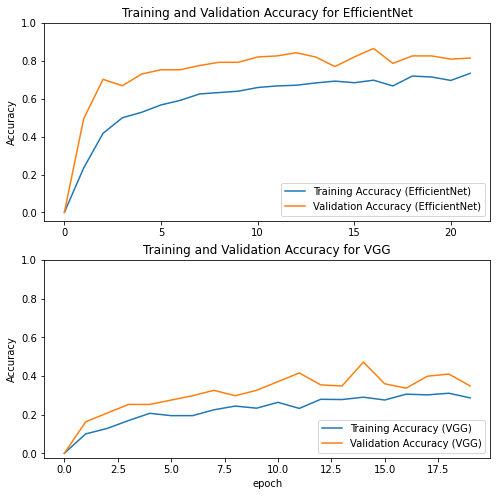

In [15]:
acc1 = [0.] + history1.history['accuracy']
val_acc1 = [0.] + history1.history['val_accuracy']

acc2 = [0.] + history2.history['accuracy']
val_acc2 = [0.] + history2.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc1, label='Training Accuracy (EfficientNet)')
plt.plot(val_acc1, label='Validation Accuracy (EfficientNet)')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy for EfficientNet')

plt.subplot(2, 1, 2)
plt.plot(acc2, label='Training Accuracy (VGG)')
plt.plot(val_acc2, label='Validation Accuracy (VGG)')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy for VGG')
plt.xlabel('epoch')
plt.show()

v. Report Precision, Recall, and F1 score for your model. Remember that this
is a multi-class classification problem

In [16]:
from tensorflow.keras.utils import to_categorical

#model1
ypred1 = model1.predict(test_dataset)
ypred1_cat = to_categorical(np.argmax(ypred1, axis=1), num_classes = num_classes)

#model2
test_ds = test_dataset.map(preprocess)
ypred2 =model2.predict(test_ds)
ypred2_cat = to_categorical(np.argmax(ypred2, axis=1), num_classes = num_classes)

37/37 [==============================] - 85s 2s/step


In [17]:
from sklearn.metrics import classification_report
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

#model 1
print(classification_report(y_true, ypred1_cat, target_names=names["Folder"]))

                               precision    recall  f1-score   support

           005.Crested_Auklet       0.78      0.88      0.82         8
                 013.Bobolink       0.88      0.78      0.82         9
           015.Lazuli_Bunting       0.83      1.00      0.91        10
         023.Brandt_Cormorant       1.00      0.70      0.82        10
   040.Olive_sided_Flycatcher       0.69      1.00      0.82         9
041.Scissor_tailed_Flycatcher       1.00      0.78      0.88         9
         067.Anna_Hummingbird       1.00      0.89      0.94         9
          072.Pomarine_Jaeger       0.82      1.00      0.90         9
          076.Dark_eyed_Junco       0.90      1.00      0.95         9
          081.Pied_Kingfisher       1.00      0.89      0.94         9
        082.Ringed_Kingfisher       1.00      0.89      0.94         9
             086.Pacific_Loon       0.75      1.00      0.86         9
                 099.Ovenbird       0.86      0.67      0.75         9
     

In [18]:
#model 2
print(classification_report(y_true, ypred2_cat, target_names=names["Folder"]))

                               precision    recall  f1-score   support

           005.Crested_Auklet       0.00      0.00      0.00         8
                 013.Bobolink       0.50      0.33      0.40         9
           015.Lazuli_Bunting       0.56      0.90      0.69        10
         023.Brandt_Cormorant       0.00      0.00      0.00        10
   040.Olive_sided_Flycatcher       0.00      0.00      0.00         9
041.Scissor_tailed_Flycatcher       0.67      0.67      0.67         9
         067.Anna_Hummingbird       0.46      0.67      0.55         9
          072.Pomarine_Jaeger       0.86      0.67      0.75         9
          076.Dark_eyed_Junco       0.25      0.11      0.15         9
          081.Pied_Kingfisher       0.53      0.89      0.67         9
        082.Ringed_Kingfisher       0.80      0.44      0.57         9
             086.Pacific_Loon       0.42      0.56      0.48         9
                 099.Ovenbird       0.29      0.22      0.25         9
     

# References:
https://stackoverflow.com/questions/69776068/how-do-i-move-a-percentage-of-files-70-15-15-split-to-different-directori <br>
https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4 <br>
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/ <br>
https://stackoverflow.com/questions/61756206/how-do-i-get-keras-predictions-to-be-one-hot-encoded <br>
